In [1]:
import pandas as pd
import numpy as np
import math
import time
import numpy as np
# If pandas is not installed, please uncomment the following line:
#!pip install pandas
#!pip install sklearn
#!pip install pathos


In [2]:
#full

def read_mimic_csv(path):
    start = time.time()
    TextFileReader = pd.read_csv(path, chunksize=100000, iterator=True, low_memory=False)
    df = pd.concat(TextFileReader, ignore_index=True)
    print(path, ":" , round(time.time() - start, 1), 'seconds')
    return df



In [3]:
path = '../../payload/' # change as needed
patients = read_mimic_csv(path + 'PATIENTS.csv')
diagnoses = read_mimic_csv(path + 'DIAGNOSES_ICD.csv')
admissions = read_mimic_csv(path + 'ADMISSIONS.csv')


../../payload/PATIENTS.csv : 0.1 seconds
../../payload/DIAGNOSES_ICD.csv : 0.3 seconds
../../payload/ADMISSIONS.csv : 0.3 seconds


In [4]:
ccs = open("../../payload/ccs.txt", "r").read()

# Create dictionary. Key is ICD9 code for a diagnosis. Value is general description of diagnosis.
ccs = ccs[ccs.find('Tuberculosis'):]
icd9={}

def update_icd9(cur_value, section):
    while section:
        if section[:4] == '\n\n':
            print('new value')
            section = section[4:]
            cur_value = section[:section.find('\n')]
            section = section[section.find('\n'):]
        elif section[0] == ' ':
            section = section[1:]
        elif section[:2] == '\n':
            section = section[2:]
        else:
            if section.find(' ') >= 0: # not end of document
                if -1 < section.find('\n') < section.find(' '): # if end of line
                    cur_key = section[:section.find('\n')]
                else: # if not end of line
                    cur_key = section[:section.find(' ')]
                section = section[section.find(' '):]
                icd9[cur_key] = cur_value

            else: # end of section
                cur_key = section
                icd9[cur_key] = cur_value
                section = ""
            
for section in ccs.split(sep='\n\n'): # for each family of codes
    cur_value = section[:section.find('\n')] # get the name for that family
    section = section[section.find('\n')+1:] # and for all the codes under that family
    update_icd9(cur_value, section) # add those codes as keys to a dictionary, where their values
                                    # are the name for the family of codes

diagnoses.ICD9_CODE = diagnoses.ICD9_CODE.apply(lambda x: icd9.get(x,-1))

#### Create LOS feature

In [5]:
df = admissions[['SUBJECT_ID',
                 'HADM_ID',
                 'ADMISSION_TYPE',
                 'ADMITTIME']].copy()

df['LOS'] = (pd.to_datetime(admissions['DISCHTIME']) - pd.to_datetime(admissions['ADMITTIME'])).astype('timedelta64[h]') 
df['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME']) 

In [6]:
df = df[df['LOS'] >= 0]
diagnoses = pd.get_dummies(diagnoses[['HADM_ID','ICD9_CODE']], drop_first=False)
diagnoses = diagnoses.groupby('HADM_ID').agg('sum')
df = pd.merge(df, diagnoses, on='HADM_ID', how='left') 
# For mortality classification, I'm keeping DOD_HOSP so I can create a boolean response for death
# NB: DOD includes ALL deaths (before & after), while DOD_HOSP only includes deaths occuring inside the hospital. 
df = pd.merge(df, # drop DOD_HOSP too if not classifying mortality
              patients.drop(columns = ['DOD', 'DOD_SSN','ROW_ID','EXPIRE_FLAG']),
              on='SUBJECT_ID',
              how='left') 

median_dob_shift = 300 - 91.4 # For old patients (median age of 91.4), dob was shifted to be 300 yrs prior to first visit
df['AGE'] = (pd.to_datetime(df['ADMITTIME']).dt.date - pd.to_datetime(df['DOB']).dt.date)
df['AGE'] = [age.days/365 if age.days/365<300 else age.days/365-median_dob_shift for age in df['AGE']]

df['DIED'] = df['DOD_HOSP'].apply(lambda x: not pd.isnull(x))

df['ADMITHOUR_trig_x'] = pd.to_datetime(df['ADMITTIME']).dt.hour.apply(math.cos)
df['ADMITHOUR_trig_y'] = pd.to_datetime(df['ADMITTIME']).dt.hour.apply(math.sin)
df['ADMITHOUR'] = pd.to_datetime(df['ADMITTIME']).dt.hour

df.drop(['DOD_HOSP','DOB'], axis=1, inplace=True)

In [7]:
print('Shape before adding dummy variables:',df.shape)
df = pd.get_dummies(df, drop_first=True)
print('Shape after adding dummy variables:', df.shape)

# It turns out ADMITHOUR after trig transform is highly predictive of whether you die

Shape before adding dummy variables: (58878, 293)
Shape after adding dummy variables: (58878, 295)


In [8]:
first_chartevents = read_mimic_csv('first_day_chartevents.csv')
first_chartevents = first_chartevents.drop(columns = ["Unnamed: 0"])
df = pd.merge(df, first_chartevents, on='HADM_ID',
              how='left') 

first_day_chartevents.csv : 0.2 seconds


In [9]:
# mandi's merged tables
first_serv_pres_micro = read_mimic_csv('first_serv_pres_micro.csv')
first_serv_pres_micro = first_serv_pres_micro.drop(columns = ['Unnamed: 0'])

hadm = first_serv_pres_micro.index.values
first_serv_pres_micro['HADM_ID'] = hadm

df = pd.merge(df, first_serv_pres_micro, on="HADM_ID", how = 'left')


first_serv_pres_micro.csv : 0.4 seconds


# LASSO

In [16]:
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split 
from sklearn import metrics, linear_model
from sklearn.model_selection import LeaveOneGroupOut
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Activation
%matplotlib inline
#import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils

In [17]:
df_demo = df

In [18]:
df_demo.drop([col for col, val in df_demo.sum().iteritems() if type(val) == int and val < 2], axis=1, inplace=True)
df_demo.shape

df_demo = df_demo.drop(columns = ["SUBJECT_ID","ADMITTIME"])
df_demo = df_demo.fillna(0)


X = df_demo.iloc[:,3:]
y = df_demo.iloc[:,1]
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.2, random_state=0)  

In [19]:
time1 = time.time()

#alphas = np.array([-1, -0.1 , 0.01, 0.1, 1, 10 , 100])
alphas = np.array([-1, 1, 10])

lassocv = linear_model.LassoCV(cv = 5)
lassocv.fit(X, y)
lassocv_score = lassocv.score(X, y)
lassocv_alpha = lassocv.alpha_

time.time() - time1

12.702288627624512

In [20]:
time1 = time.time()

lasso = Lasso(alpha = lassocv_alpha)#, max_iter = 10e6)
lasso.fit(X_train_demo, y_train_demo)
train_score = lasso.score(X_train_demo, y_train_demo)
test_score = lasso.score(X_test_demo, y_test_demo)
coef_used = np.sum(lasso.coef_ != 0)

print('training score: ', train_score)
print('test score: ', test_score)
print('number of features used: ', coef_used)

time.time() - time1

training score:  0.4268066049780428
test score:  0.4308138700610733
number of features used:  120


5.596412420272827

In [21]:
zeros = []

used = []

for i in range(len(lasso.coef_ )):
    if lasso.coef_[i] == 0:
        zeros += [i]
    else:
        used += [i]

#test to see what it looks like:
#X.iloc[0:10, used]

In [22]:
filtered = X.iloc[:, used]
filtered['LOS'] = y

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# MLP

In [23]:
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

In [24]:
# If pandas is not installed, please uncomment the following line:
#!pip install pandas
#!pip install sklearn
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils

ModuleNotFoundError: No module named 'd2l'

In [98]:
bert = pd.read_pickle('bert.pkl')

In [99]:
bert_df = pd.merge(df_demo, bert, on='HADM_ID',
              how='left') 

In [100]:
bert_df['VEC'] = bert_df['VEC'].apply(lambda d: d if isinstance(d, np.ndarray) else [[0]]*768)
bert_df = pd.merge(bert_df.iloc[:,:-1], 
                   pd.DataFrame(bert_df.VEC.values.tolist(), index= bert_df.HADM_ID).applymap(lambda x: x[0]),
                   on='HADM_ID',
                   how='inner')

In [97]:
#post lasso data
#filtered = pd.read_csv('filtered.csv') 
filtered['VEC'] = bert_df.iloc[:,bert_df.shape[1]-1]

In [103]:
# if when u run lasso, there are different number of features,
# just put labels as last column below.
X = bert_df.drop(columns = ['LOS','DIED'])
y = bert_df['LOS']

# ISSUE:
can't figure out how to run with bert vector. take out below and run model

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [106]:
from keras import regularizers
model = Sequential()
model.add(Dense(512, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
#model.add(Dense(64, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(1))
#model.compile(loss = 'rmse', optimizer = 'adam')
model.compile(loss = 'msle', optimizer = 'adam')

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'training data dims: X: {X_train.shape}, y: {y_train.shape}')
print(f'test data dims: X: {X_test.shape}, y: {y_test.shape}')

history = model.fit(X_train, y_train, epochs = 50, batch_size=256)


training data dims: X: (47102, 1180), y: (47102,)
test data dims: X: (11776, 1180), y: (11776,)
Epoch 1/50
 2560/47102 [>.............................] - ETA: 1:44 - loss: 35.9834

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.00390625). Is this intended?
  force_init=force_init)


47102/47102 [==============================] - 7s 156us/step - loss: 18.6139
Epoch 2/50
47102/47102 [==============================] - 1s 29us/step - loss: 9.8857
Epoch 3/50
47102/47102 [==============================] - 1s 30us/step - loss: 5.6056
Epoch 4/50
47102/47102 [==============================] - 1s 31us/step - loss: 3.8719
Epoch 5/50
47102/47102 [==============================] - 1s 30us/step - loss: 2.9423
Epoch 6/50
47102/47102 [==============================] - 1s 29us/step - loss: 2.3722
Epoch 7/50
47102/47102 [==============================] - 1s 30us/step - loss: 1.9966
Epoch 8/50
47102/47102 [==============================] - 2s 32us/step - loss: 1.7368
Epoch 9/50
47102/47102 [==============================] - 1s 32us/step - loss: 1.5688
Epoch 10/50
47102/47102 [==============================] - 2s 32us/step - loss: 1.4400
Epoch 11/50
47102/47102 [==============================] - 1s 32us/step - loss: 1.3777
Epoch 12/50
47102/47102 [==============================] - 2s

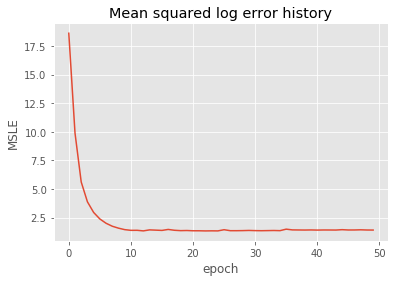

In [107]:
plt.plot(history.history['loss'])
plt.title('Mean squared log error history')
plt.xlabel('epoch')
plt.ylabel('MSLE')
plt.show()

In [108]:
predictions = model.predict(X_test)
predictions = predictions.reshape(len(y_test), )
difference = predictions - y_test 
accuracy = sum(abs(difference) <= 48) /len(y_test)
print(accuracy)

0.286430027173913
